# Atividade 1 da Disciplica de Machine Learning
## Alunos - Matrícula: 
    Gabriel Miranda - 202100011430
    Rafael Takeguma -
    Arthur Santos   -
## Etapa 1: Pré-processamento dos dados

Abrindo o dataset em um dataframe pandas

In [27]:
import pandas as pd

df = pd.read_csv("dataset.csv")
df = df.dropna()
df.head()

,curriculum_id,student_id,centro,department_name,course_name,student_age_at_initial_period,birthday,birth_place,ingress_form,locks_number,required_ch_progress,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,122,97,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,30,1964-05-14,PORTO ALEGRE/RS,TRANSFERÊNCIA COMPULSÓRIA,0,4.605.263.157.894.730,100,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537.049.312.853.680,0.3,476.704.122.877.932,0.3,5.301.382.376.717.860,1.611
1,215,167,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1980-05-11,ARACAJU/SE,VESTIBULAR,0,9.534.883.720.930.230,100,CANCELADO,ABANDONO,6.69,4.537.049.312.853.680,0.3,476.704.122.877.932,367.0,5.301.382.376.717.860,7.366
2,348,285,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,19,1983-10-26,ARACAJU/SE,VESTIBULAR,0,9.767.441.860.465.110,100,CANCELADO,ABANDONO,6.66,4.537.049.312.853.680,0.3,476.704.122.877.932,446.0,5.301.382.376.717.860,8.911
3,352,289,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1981-08-08,RIO DE JANEIRO/RJ,VESTIBULAR,0,100,100,CANCELADO,ABANDONO,6.71,4.537.049.312.853.680,0.3,476.704.122.877.932,411.0,5.301.382.376.717.860,8.273
4,414,351,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1986-02-10,ARACAJU/SE,VESTIBULAR,0,100,100,CONCLUÍDO,CONCLUÍDO,6.55,4.537.049.312.853.680,325.0,476.704.122.877.932,429.0,5.301.382.376.717.860,9.132


Exibindo informações gerais sobre o dataset

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1514 entries, 0 to 2535
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  1514 non-null   int64  
 1   student_id                     1514 non-null   int64  
 2   centro                         1514 non-null   object 
 3   department_name                1514 non-null   object 
 4   course_name                    1514 non-null   object 
 5   student_age_at_initial_period  1514 non-null   int64  
 6   birthday                       1514 non-null   object 
 7   birth_place                    1514 non-null   object 
 8   ingress_form                   1514 non-null   object 
 9   locks_number                   1514 non-null   int64  
 10  required_ch_progress           1514 non-null   object 
 11  optative_ch_progress           1514 non-null   object 
 12  curriculum_status              1514 non-null   object

Exibindo as colunas numéricas do dataset

In [29]:
df.describe()

,curriculum_id,student_id,student_age_at_initial_period,locks_number,mc,iepl,iech,iea
count,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000
mean,2074.133421,1845.038309,21.842140,0.219287,4.100271,231.600149,285.009333,54.667489
std,737.974055,689.459947,5.357002,0.480414,2.769070,311.780680,341.324874,165.633918
min,122.000000,55.000000,16.000000,0.000000,0.000000,0.300000,0.300000,0.000000
25%,1505.250000,1321.000000,18.000000,0.000000,1.432500,0.300000,0.300000,1.522525
50%,2120.500000,1881.500000,20.000000,0.000000,4.530000,0.300000,0.500000,3.376900
75%,2617.250000,2351.750000,23.000000,0.000000,6.590000,490.500000,585.000000,6.284675
max,3923.000000,3382.000000,54.000000,2.000000,9.390000,997.000000,991.000000,999.000000


Definindo os dtypes corretos das colunas de acordo com a explicação dos atributos do dataset.

In [30]:
#df = df['required_ch_progress'].astype('float64')

Inicialmente, removeremos colunas que não se mostram importantes para a predição da evasão, como: matrícula, data de nascimento, local de nascimento, id do estudante, centro e nome do departamento.
Outros campos podem ser removidos posteriormente, depois de análises mais detalhadas.

In [31]:
df = df.drop(columns=['curriculum_id', 'student_id', 'centro', 'department_name', 'birthday', 'birth_place'])
df.head()

,course_name,student_age_at_initial_period,ingress_form,locks_number,required_ch_progress,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,CIÊNCIA DA COMPUTAÇÃO,30,TRANSFERÊNCIA COMPULSÓRIA,0,4.605.263.157.894.730,100,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537.049.312.853.680,0.3,476.704.122.877.932,0.3,5.301.382.376.717.860,1.611
1,CIÊNCIA DA COMPUTAÇÃO,18,VESTIBULAR,0,9.534.883.720.930.230,100,CANCELADO,ABANDONO,6.69,4.537.049.312.853.680,0.3,476.704.122.877.932,367.0,5.301.382.376.717.860,7.366
2,CIÊNCIA DA COMPUTAÇÃO,19,VESTIBULAR,0,9.767.441.860.465.110,100,CANCELADO,ABANDONO,6.66,4.537.049.312.853.680,0.3,476.704.122.877.932,446.0,5.301.382.376.717.860,8.911
3,CIÊNCIA DA COMPUTAÇÃO,21,VESTIBULAR,0,100,100,CANCELADO,ABANDONO,6.71,4.537.049.312.853.680,0.3,476.704.122.877.932,411.0,5.301.382.376.717.860,8.273
4,CIÊNCIA DA COMPUTAÇÃO,18,VESTIBULAR,0,100,100,CONCLUÍDO,CONCLUÍDO,6.55,4.537.049.312.853.680,325.0,476.704.122.877.932,429.0,5.301.382.376.717.860,9.132


Após remoção inicial, utilizamos a função hist() para vizualizar os dados numéricos em forma de histograma.

Dessa forma verificamos a distribuição dos dados e suas escalas.

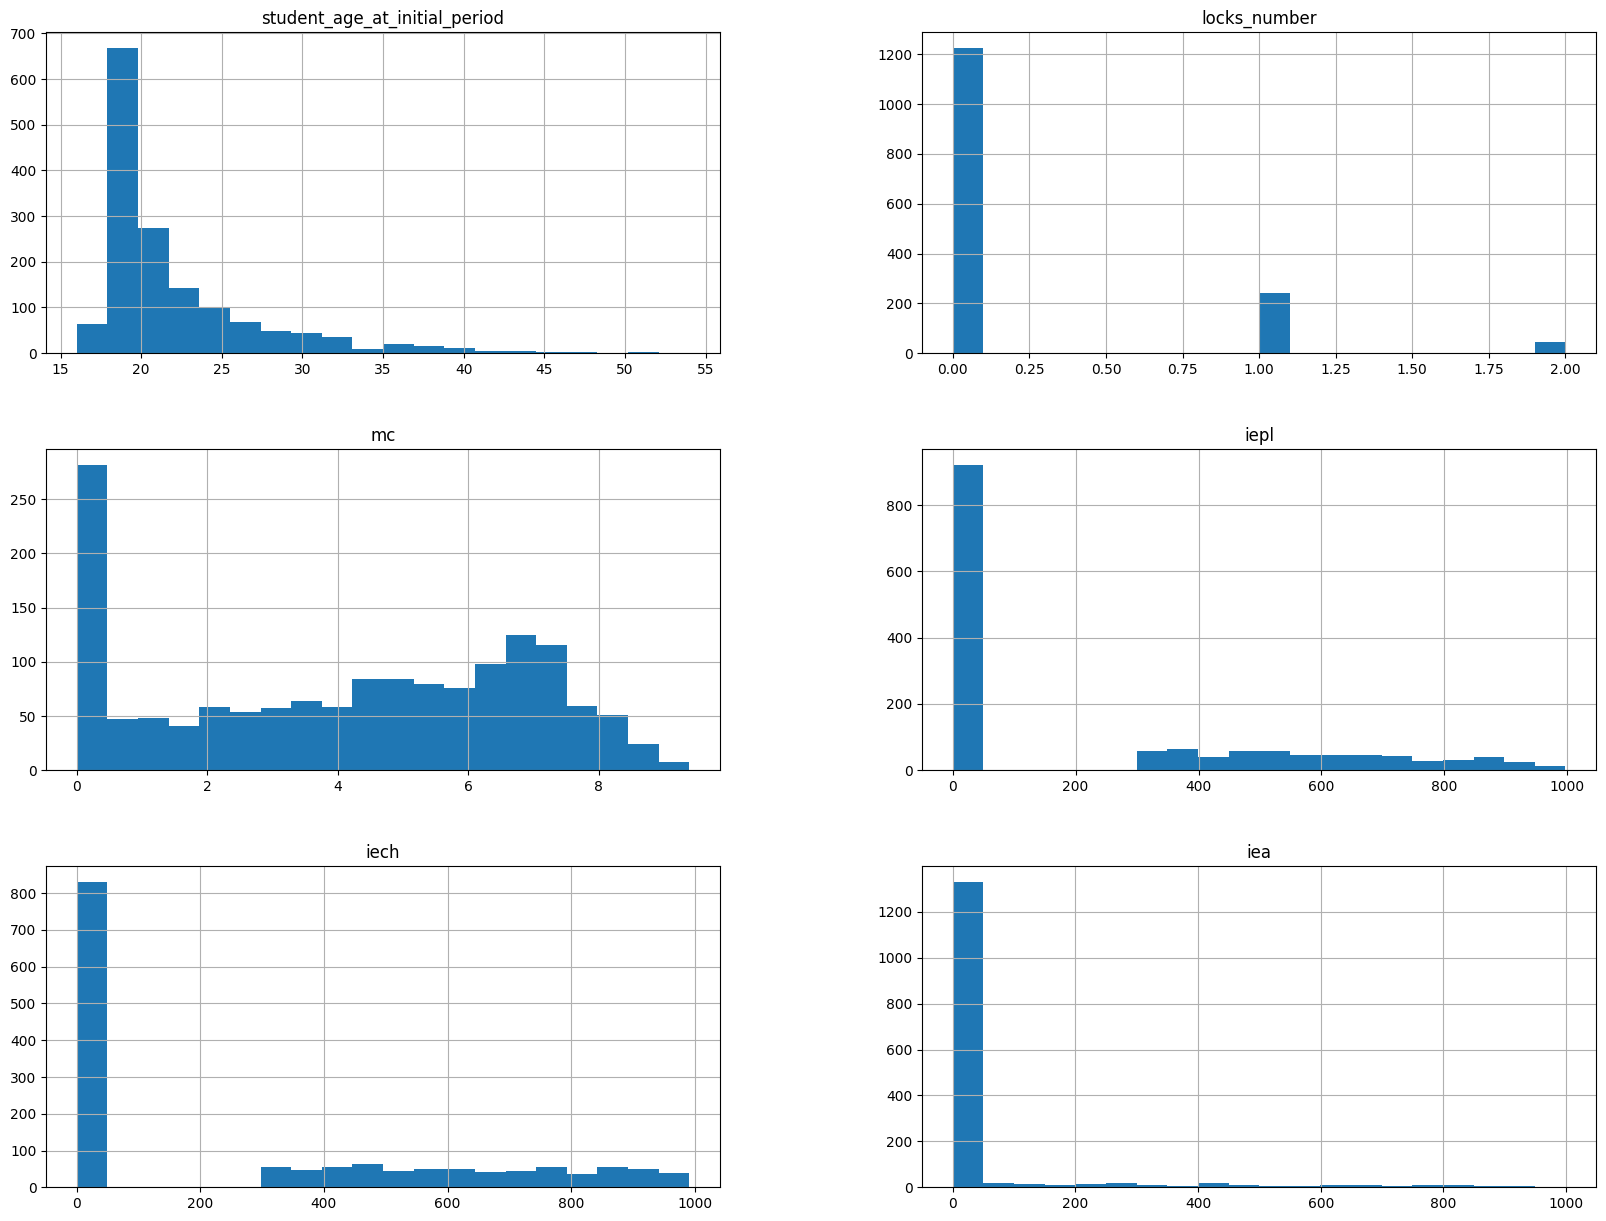

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=20, figsize=(20,15))
plt.show()

Verificação da importância das colunas restantes

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Separação do dataframe em features e target
X = df.select_dtypes('int64', 'float64')
y = df['leaving_reason']

clf = RandomForestClassifier(random_state=42)
clf.fit(X,y)

# Dataframe da importância
importancia = pd.DataFrame({'Variável': X.columns, 'Importância': clf.feature_importances_})
importancia = importancia.sort_values(by="Importância", ascending=False)
#importancia
df

,course_name,student_age_at_initial_period,ingress_form,locks_number,required_ch_progress,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,CIÊNCIA DA COMPUTAÇÃO,30,TRANSFERÊNCIA COMPULSÓRIA,0,4.605.263.157.894.730,100,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537.049.312.853.680,0.3,476.704.122.877.932,0.3,5.301.382.376.717.860,1.6110
1,CIÊNCIA DA COMPUTAÇÃO,18,VESTIBULAR,0,9.534.883.720.930.230,100,CANCELADO,ABANDONO,6.69,4.537.049.312.853.680,0.3,476.704.122.877.932,367.0,5.301.382.376.717.860,7.3660
2,CIÊNCIA DA COMPUTAÇÃO,19,VESTIBULAR,0,9.767.441.860.465.110,100,CANCELADO,ABANDONO,6.66,4.537.049.312.853.680,0.3,476.704.122.877.932,446.0,5.301.382.376.717.860,8.9110
3,CIÊNCIA DA COMPUTAÇÃO,21,VESTIBULAR,0,100,100,CANCELADO,ABANDONO,6.71,4.537.049.312.853.680,0.3,476.704.122.877.932,411.0,5.301.382.376.717.860,8.2730
4,CIÊNCIA DA COMPUTAÇÃO,18,VESTIBULAR,0,100,100,CONCLUÍDO,CONCLUÍDO,6.55,4.537.049.312.853.680,325.0,476.704.122.877.932,429.0,5.301.382.376.717.860,9.1320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,ENGENHARIA DE COMPUTAÇÃO,30,VESTIBULAR,1,7.291.666.666.666.660,0,CANCELADO,CANCELAMENTO ESPONTÂNEO,5.13,4.697.231.222.385.860,551.0,5.112.106.038.291.610,318.0,5.510.486.008.836.530,8.9890
2510,ENGENHARIA DE COMPUTAÇÃO,19,VESTIBULAR,0,22.916.666.666.666.600,0,CANCELADO,CANCELAMENTO ESPONTÂNEO,6.39,4.697.231.222.385.860,577.0,5.112.106.038.291.610,786.0,5.510.486.008.836.530,2.8980
2516,ENGENHARIA DE COMPUTAÇÃO,19,VESTIBULAR,0,28.125,42.857.142.857.142.800,CANCELADO,Transferência Interna,6.86,4.697.231.222.385.860,984.0,5.112.106.038.291.610,886.0,5.510.486.008.836.530,5.9807
2524,ENGENHARIA DE COMPUTAÇÃO,18,VESTIBULAR,0,2.083.333.333.333.330,0,CANCELADO,NÃO CONFIRMAÇÃO VÍNCULO,0.00,4.697.231.222.385.860,0.3,5.112.106.038.291.610,0.3,5.510.486.008.836.530,0.0000


Primeiro, será realizada uma "poda" inicial dos dados, removendo colunas que não representam correlação com a evasão do curso

In [34]:
#df = df.